#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Finite difference/collocation methods

Consider the boundary value problem

$$ \begin{gather} -\frac{d^2 u}{dx^2} = f(x) \quad x \in \Omega = (-1,1) \\
u(-1) = a \quad \frac{du}{dx}(1) = b . \end{gather} $$

$f(x)$ is the "forcing" term and we have a Dirichlet boundary condition at the left end of the domain and a Neumann condition on the right end.  We need to choose
* how to represent $u(x)$, including evaluating it on the boundary,
* how to compute derivatives of $u$,
* in what sense to ask for the differential equation to be satisfied,
* where to evaluate $f(x)$ or integrals thereof,
* how to enforce boundary conditions.

## The framework

* Finite difference (FD) methods choose to represent the function $u(x)$ by its values $u_i = u(x_i)$ at a discrete set of points $$ -1 = x_0 < x_1 < \dotsb < x_n = 1 . $$
The FD framework does not uniquely specify the solution values at points outside this discrete set.
* FD computes derivatives at $x_i$ via differencing formulas involving a finite number of neighbor points (independent of the total number of points $n$).  This will be our main focus.
* FD methods ask for the differential equation to be satisfied pointwise at each $x_i$ in the interior of the domain.
* FD methods evaluate the forcing term $f$ pointwise at $x_i$.
* FD methods approximate derivatives at discrete boundary points ($x_n = 1$ above), typically using one-sided differencing formulas.

## Differencing formulas

How can we compute $\frac{du}{dx}(x_i)$ using $u_i$ and $u_{i+1}$?  How accurate is this approximation?

### Taylor series

Without loss of generality, we may assume $x_i = 0$ by shifting our function.  For notational convenience, we will also define $h = x_{i+1} - x_i$.
To determine the order of accuracy, we represent the function $u(x)$ by its Taylor series
$$ u(x) = u(0) + u'(0)x + u''(0)x^2/2! + O(x^3)$$
and substitute into the differencing formula
$$ \begin{split} u'(0) \approx \frac{u(h) - u(0)}{h} = h^{-1} \Big( u(0) + u'(0) h + u''(0)h^2/2 + O(h^3) - u(0) \Big) \\
= u'(0) + u''(0)h/2 + O(h^2) . \end{split}$$
Evidently the error in this approximation is $u''(0)h/2 + O(h^2)$. We say this method is *first order accurate*.

<IPython.core.display.Javascript object>


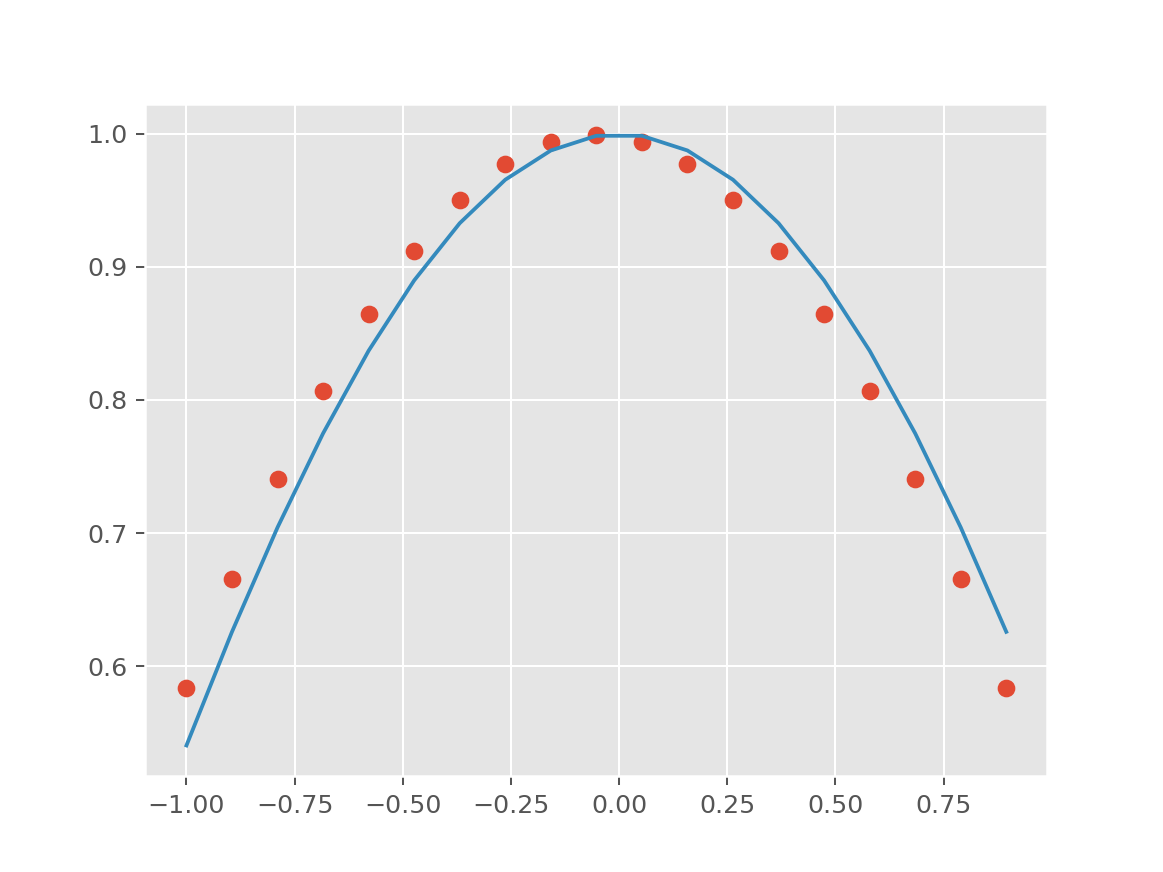

In [1]:
%matplotlib notebook
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

n = 20
h = 2/(n-1)
x = numpy.linspace(-1,1,n)
u = numpy.sin(x)
pyplot.figure()
pyplot.plot(x[:-1], (u[1:] - u[:-1]) / h, 'o')
pyplot.plot(x[:-1], numpy.cos(x[:-1]))

This "has the right shape", but the numerical approximation is "shifted" to the left of the analytic derivative. If we differenced to the left, it would be shifted the other way.

####  Is the centered difference formula better?

Here we try

$$ \begin{split} u'(0) \approx \frac{u(h) - u(-h)}{2h} \\
= (2h)^{-1} \Big( \big[ u(0) + u'(0)h + u''(0)h^2/2 + u'''(0)h^3/6 + O(h^4) \Big] - \big[ u(0) - u'(0)h + u''(0)h^2/2 - u'''(0)h^3/6 + O(h^4) \big] \Big) \\
= u'(0) + u'''(0)h^2/6 + O(h^3) \end{split} $$

<IPython.core.display.Javascript object>


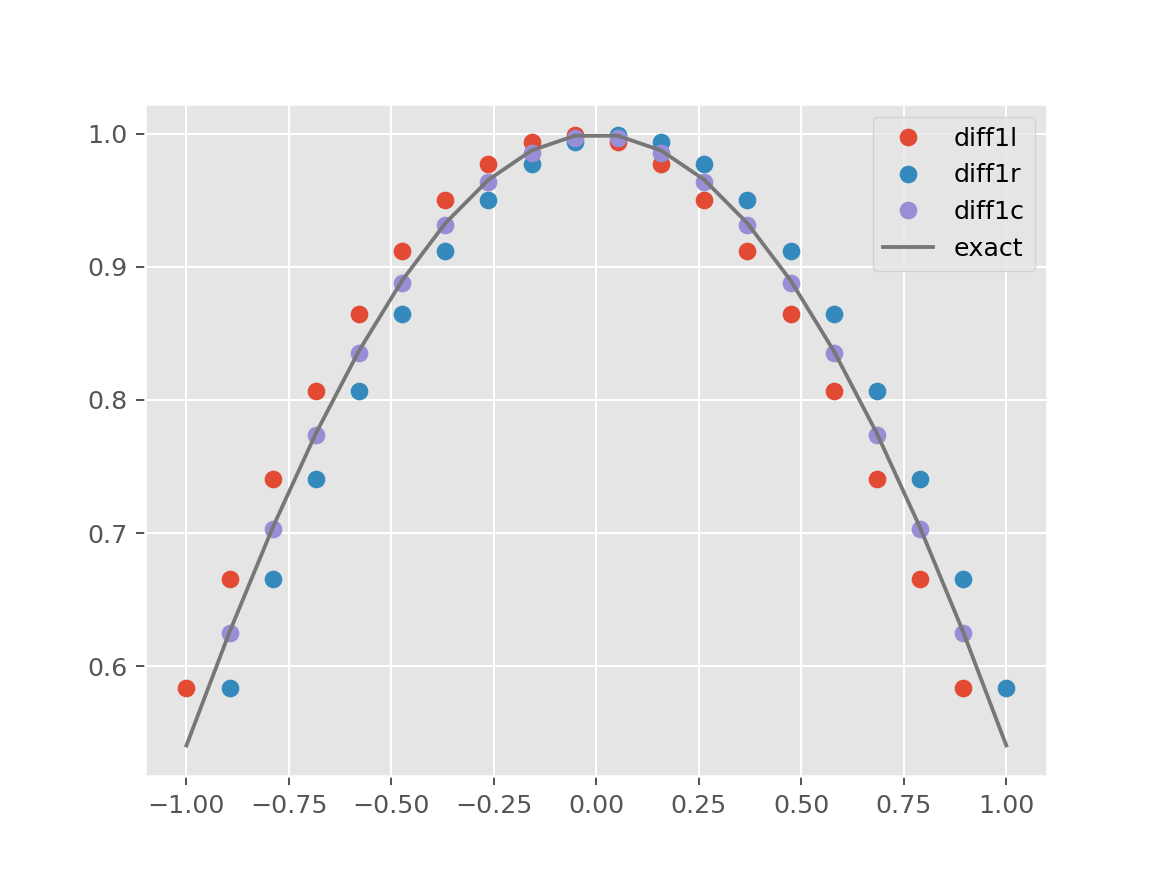

In [2]:
def diff1l(x, u):
    return x[:-1], (u[1:] - u[:-1]) / (x[1:] - x[:-1])

def diff1r(x, u):
    return x[1:],  (u[1:] - u[:-1]) / (x[1:] - x[:-1])

def diff1c(x, u):
    return x[1:-1], (u[2:] - u[:-2]) / (x[2:] - x[:-2])

pyplot.figure()
for diff in (diff1l, diff1r, diff1c):
    xx, yy = diff(x, u)
    pyplot.plot(xx, yy, 'o', label=diff.__name__)
pyplot.plot(x, numpy.cos(x), label='exact')
pyplot.legend(loc='upper right')

<IPython.core.display.Javascript object>


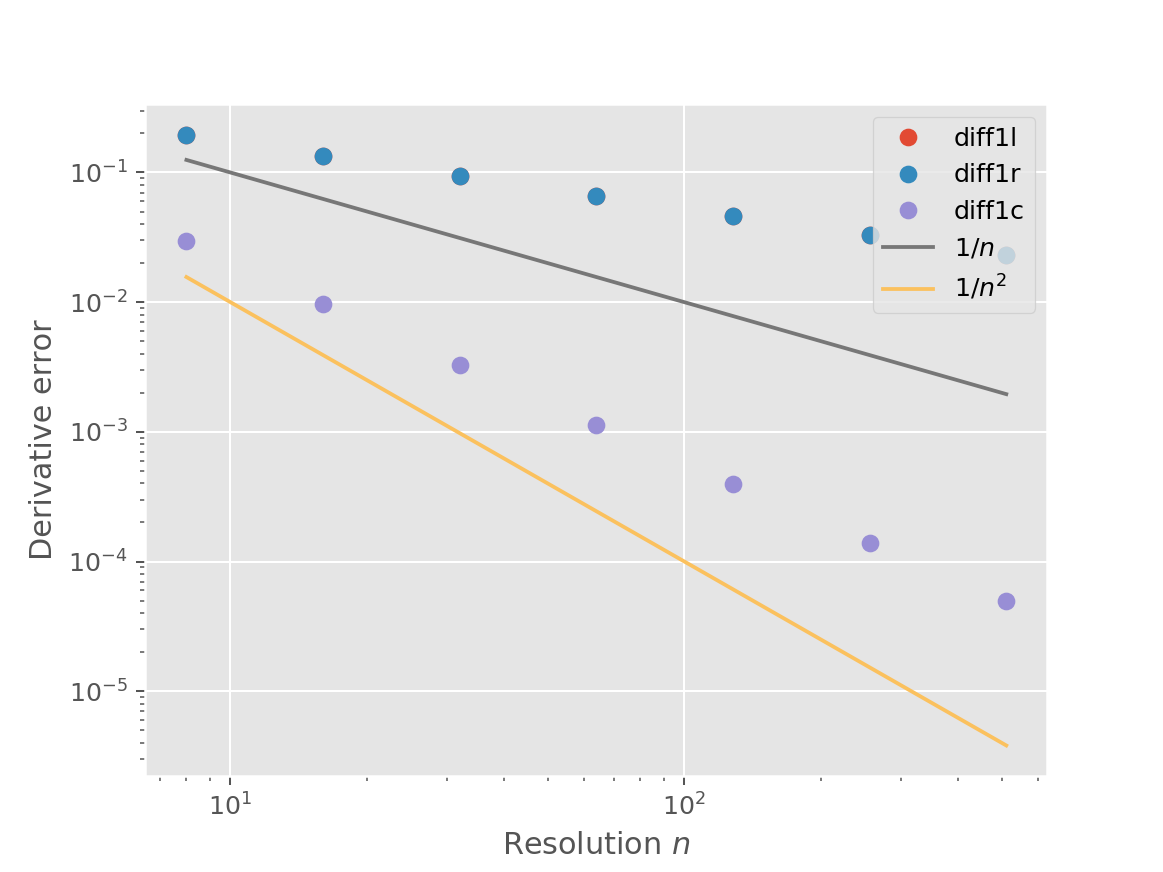

In [3]:
grids = 2**numpy.arange(3,10)
def grid_refinement_error(f, fp, diff):
    error = []
    for n in grids:
        x = numpy.linspace(-1, 1, n)
        xx, yy = diff(x, f(x))
        error.append(numpy.linalg.norm(yy - fp(xx)))
    return grids, error

pyplot.figure()
for diff in (diff1l, diff1r, diff1c):
    ns, error = grid_refinement_error(numpy.sin, numpy.cos, diff)
    pyplot.loglog(ns, error, 'o', label=diff.__name__)
pyplot.loglog(grids, grids**(-1.), label='$1/n$')
pyplot.loglog(grids, grids**(-2.), label='$1/n^2$')
pyplot.xlabel('Resolution $n$')
pyplot.ylabel('Derivative error')
pyplot.legend(loc='upper right')

#### Stability

Are there "rough" functions for which these differencing formulas estimate $u'(x_i) = 0$?

<IPython.core.display.Javascript object>


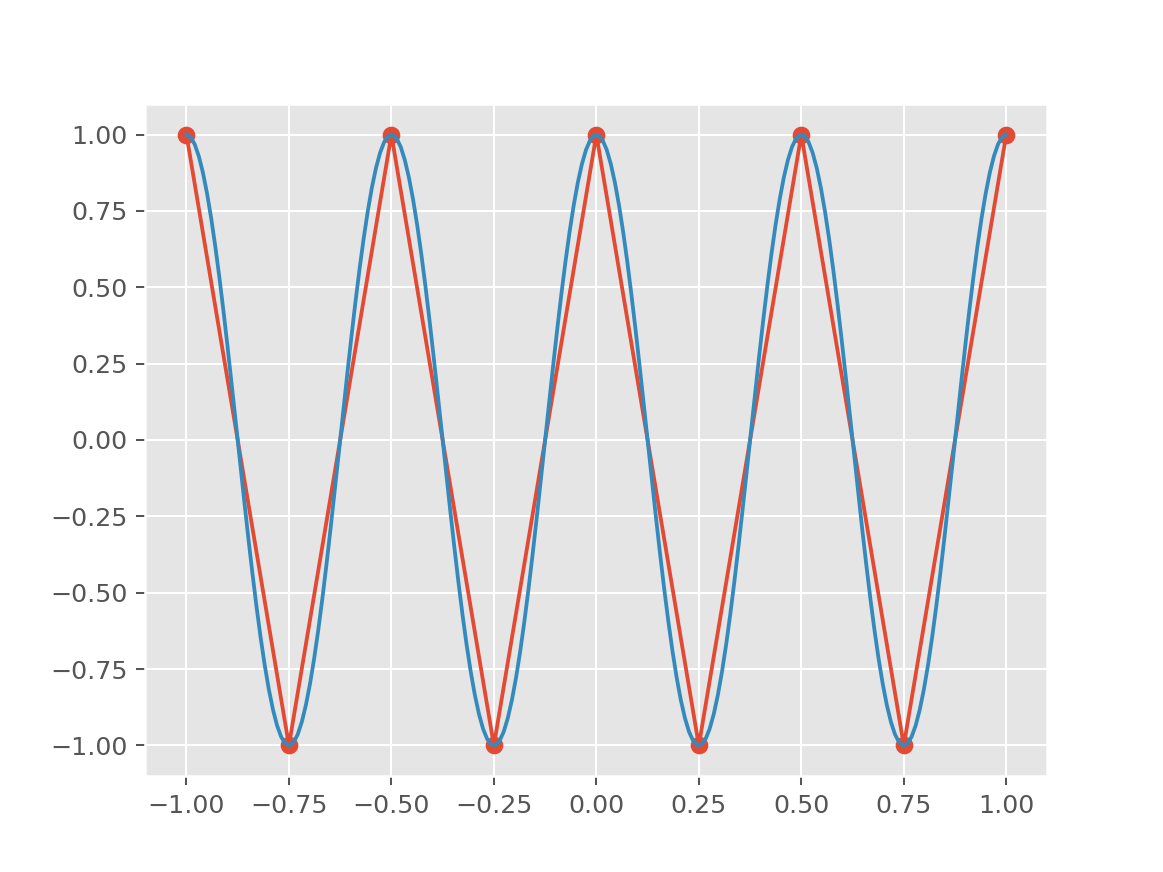

In [4]:
x = numpy.linspace(-1, 1, 9)
xfine = numpy.linspace(-1, 1, 200)
def f_rough(x):
    return numpy.cos(4*numpy.pi*x)
def fp_rough(x):
    return -4*numpy.pi * numpy.sin(4*numpy.pi*x)

pyplot.figure()
pyplot.plot(x, f_rough(x), 'o-')
pyplot.plot(xfine, f_rough(xfine), '-')

<IPython.core.display.Javascript object>


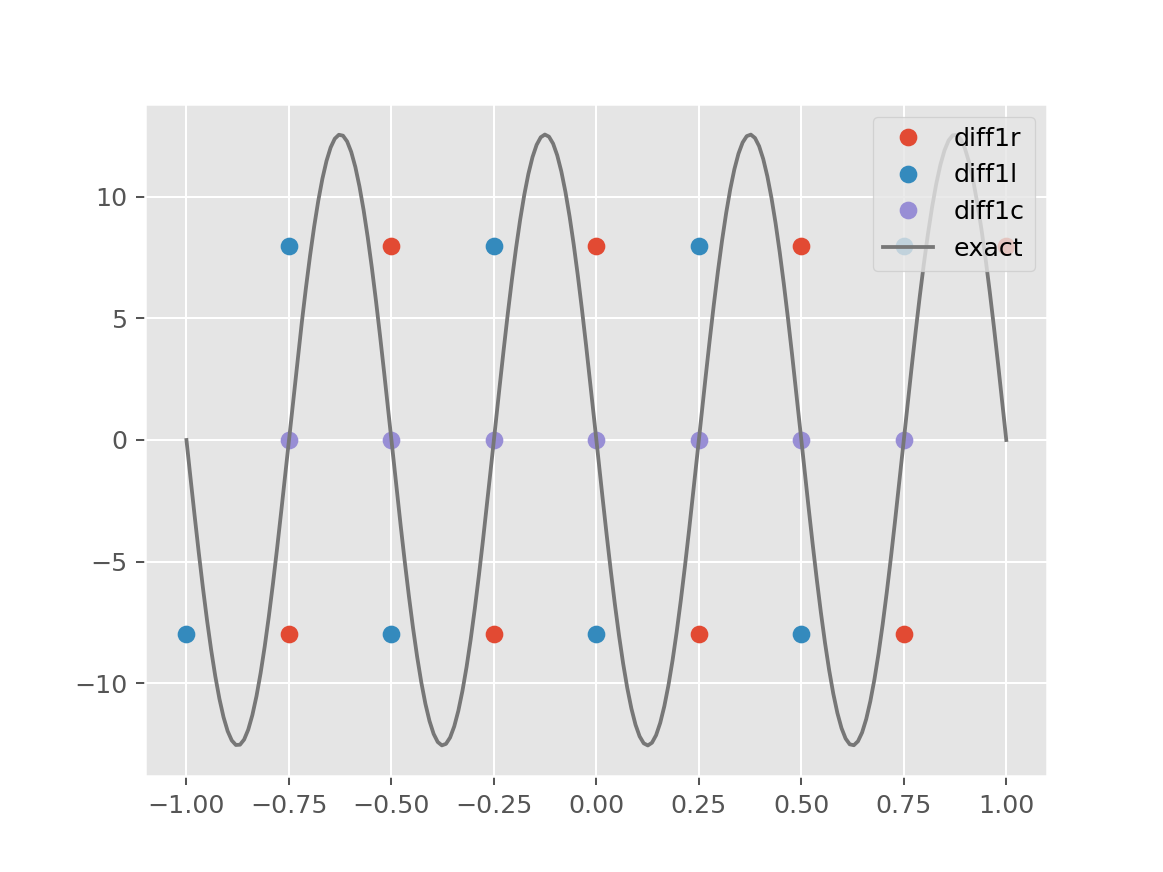

In [5]:
pyplot.figure()
for diff in (diff1r, diff1l, diff1c):
    xx, yy = diff(x, f_rough(x))
    pyplot.plot(xx, yy, 'o', label=diff.__name__)
pyplot.plot(xfine, fp_rough(xfine), label='exact')
pyplot.legend(loc='upper right')

We have this function $f_{\text{rough}}(x)$ that is rough at the grid scale and has derivative identically zero according to the centered difference formula.  Except perhaps for boundary conditions (which we'll consider later), given any solution $u(x)$ to a differential equation discretized using the centered difference approximation, $$\tilde u(x) = u(x) + f_{\text{rough}}(x)$$ would also be a solution.  This non-uniqueness is a disaster for numerical algorithms and in most cases, the centered difference formula is not used directly to compute first derivatives.

When assessing a discretization we require **both accuracy and stability**.

### Second derivatives

We will need at least three grid points to compute a second derivative.
* Why?

Again, there is more than one possible approach.
* One method is to use a first derivative formula to compute $u'(x_{i+1})$ and $u'(x_{i-1})$, then apply the centered first derivative again.
* Another is to define some "staggered" points $x_{i+1/2}$ and $x_{i-1/2}$.

Why should we choose one over the other? Can we understand this in terms of accuracy and stability?

<IPython.core.display.Javascript object>


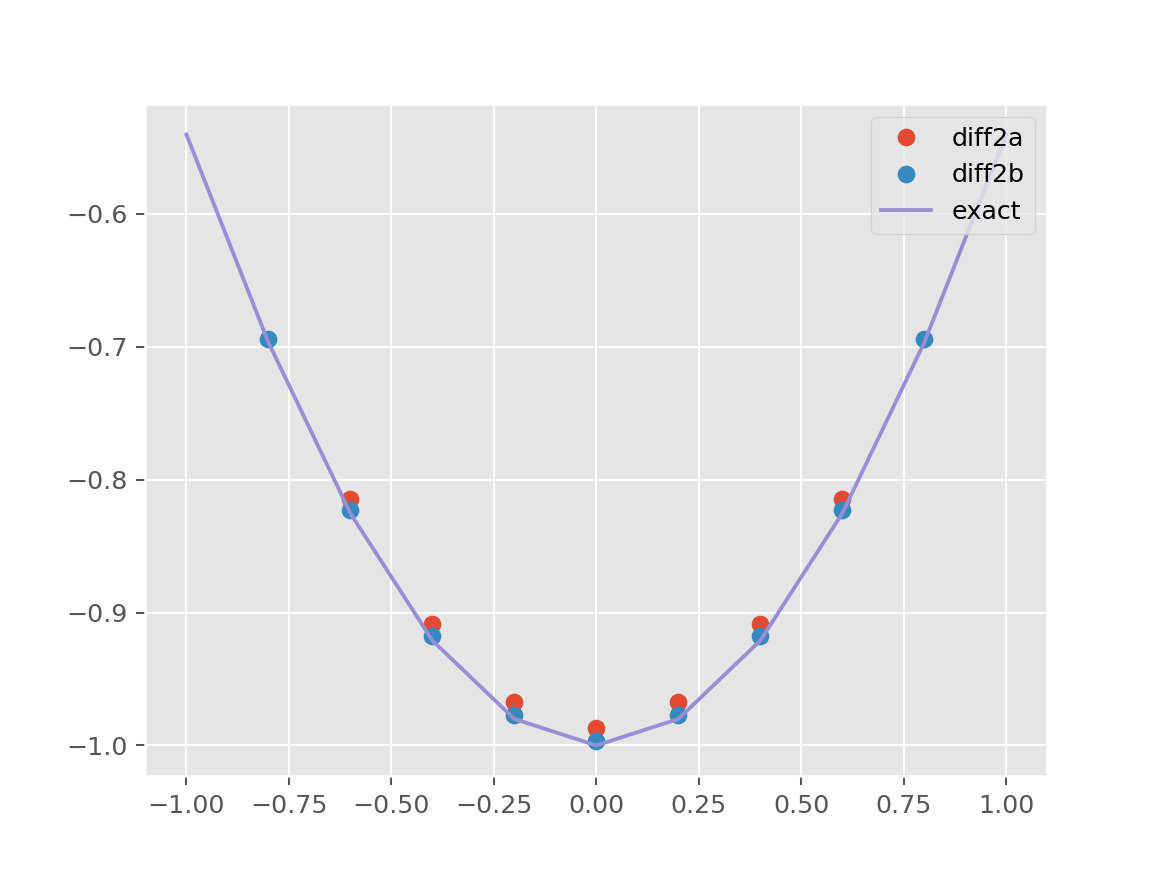

In [6]:
def diff2a(x, u):
    xx, yy = diff1c(x, u)
    return diff1c(xx, yy)

def diff2b(x, u):
    xx, yy = diff1l(x, u)
    return diff1r(xx, yy)

x = numpy.linspace(-1, 1, 11)
u = numpy.cos(x)
pyplot.figure()
for diff2 in (diff2a, diff2b):
    xx, yy = diff2(x, u)
    pyplot.plot(xx, yy, 'o', label=diff2.__name__)
pyplot.plot(x, -numpy.cos(x), label='exact')
pyplot.legend(loc='upper right')

<IPython.core.display.Javascript object>


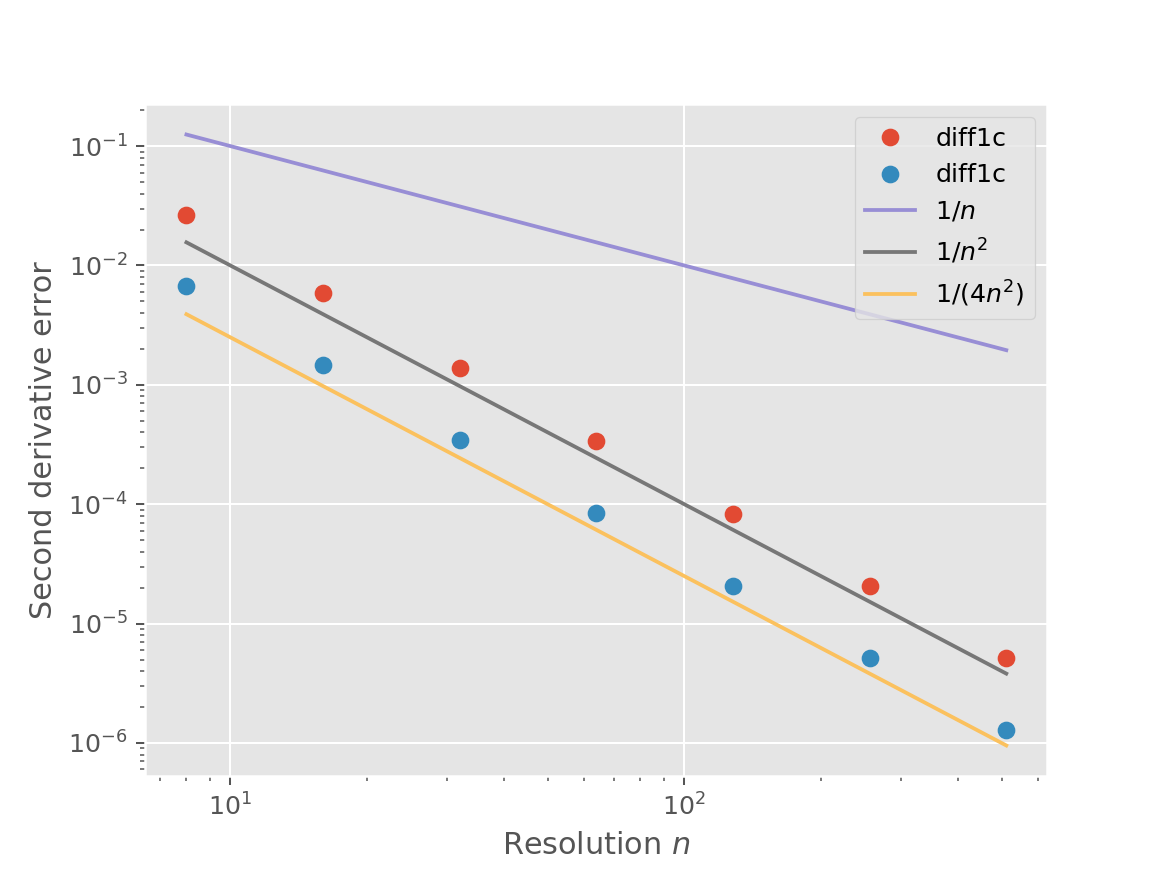

In [7]:
def grid_refinement_error2(f, fpp, diff):
    error = []
    for n in grids:
        x = numpy.linspace(-1, 1, n)
        xx, yy = diff(x, f(x))
        error.append(numpy.linalg.norm(yy - fpp(xx), numpy.inf))
    return grids, error

pyplot.figure()
for diff2 in (diff2a, diff2b):
    ns, error = grid_refinement_error2(numpy.cos, lambda x: -numpy.cos(x), diff2)
    pyplot.loglog(ns, error, 'o', label=diff.__name__)
pyplot.loglog(grids, grids**(-1.), label='$1/n$')
pyplot.loglog(grids, grids**(-2.), label='$1/n^2$')
pyplot.loglog(grids, .25*grids**(-2.), label='$1/(4n^2)$')
pyplot.xlabel('Resolution $n$')
pyplot.ylabel('Second derivative error')
pyplot.legend(loc='upper right')

#### Observations

* Both methods are second order accurate
* The `diff2a` method is more accurate by a factor of 4
* The `diff2b` method cannot compute the derivative at points next to the boundary
* We don't know yet whether either method is stable

## Differentiation as matrices

So far we have written functions of the form `diff(x, u)` that compute derivatives.  These functions happen to have been linear in `u`.  We should be able to write differentiation as a matrix $D$ such that

$$ u'(x) = D u(x) $$

where $x$ is the vector of $n$ discrete points, thus $u(x)$ is also a vector of length $n$.

### Homework 0

* Fork the class repository, clone, and create a directory `hw0` inside the repository.  Add your source file(s) to that directory.
* Write a function `diffmat(x)` that returns a matrix $D$ that computes first derivatives.
* Write a function `diff2mat(x)` that returns a matrix $D_2$ that computes second derivatives.
* Use test functions to determine the order of accuracy of your methods.
* Note: you'll need to think about what to do at the endpoints.